<a href="https://colab.research.google.com/github/fahmij8/Bangkit-Final-Project/blob/master/Mobile_Net_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'aflita'
os.environ['KAGGLE_KEY'] = 'cad9302366db38692e6dfc19fee87783'

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import numpy as np
import pickle
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from IPython.display import Image, display
from tqdm import tqdm
from keras.preprocessing import image
#from keras.models import Model

Using TensorFlow backend.


In [ ]:
!kaggle datasets download -d shadabhussain/flickr8k
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation

100% 2.12G/2.13G [00:58<00:00, 37.4MB/s]
100% 2.13G/2.13G [00:58<00:00, 39.1MB/s]
 98% 447M/458M [00:13<00:00, 37.0MB/s]
100% 458M/458M [00:13<00:00, 35.3MB/s]


In [ ]:
!unzip -q flickr8k.zip -d .
!unzip -q glove-global-vectors-for-word-representation.zip -d .

In [ ]:
# Read Image Folder
image_folder = '/content/Flickr_Data/Flickr_Data/Images/'
# Read Annotation Folder
annotation_file = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
# Read Training File
train_file = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
# Read Validation File
val_file = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
# Read Test File
test_file = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
# Read GloVe File
glove_file ='/content/glove.6B.50d.txt'

In [ ]:
unique_train = open(train_file, 'r').read().splitlines()
unique_val = open(val_file, 'r').read().splitlines()
unique_test = open(test_file, 'r').read().splitlines()
annotations = open(annotation_file,'r').read().splitlines()

In [ ]:
# Collect Dataset
import re

def collect_list(unique_set):
  data = []
  for idx, el in enumerate(annotations):
    # Split Image ID with Captions
    fname, cap = re.split("#[0-9][\t]", el)
    cap = cap.split()
    cap = [w for w in cap if len(w)>1]
    cap = ' '.join(cap)
    cap = '<start> ' + cap + ' <end>'
    cap = cap.lower()
    if fname in unique_set:
      data.append([fname,cap])
  return data

train_set = collect_list(unique_train)
val_set = collect_list(unique_val)
test_set = collect_list(unique_test)

print('Collected Train Sets: %d' %len(train_set))
print('Collected Val Sets: %d' %len(val_set))
print('Collected Test Sets: %d' %len(test_set))
print('\n')
print('Unique Train Sets: %d' %len(unique_train))
print('Unique Val Sets: %d' %len(unique_val))
print('Unique Test Sets: %d' %len(unique_test))

Collected Train Sets: 30000
Collected Val Sets: 5000
Collected Test Sets: 5000


Unique Train Sets: 6000
Unique Val Sets: 1000
Unique Test Sets: 1000


**Define Model**

In [ ]:
# Optional
# Define Baseline CNN Model
from tensorflow import keras

baseline_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation= 'relu', input_shape = (224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'softmax')
])

baseline_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#baseline_model.summary()
baseline = tf.keras.Model(inputs = baseline_model.input,
                          outputs = baseline_model.layers[-3].output)
baseline.summary()

In [ ]:
# Transfer Learning MobileNet
from keras.applications.mobilenet import MobileNet
from keras.models import Model, Sequential

mobilenet = tf.keras.applications.MobileNet(weights='imagenet',include_top = True, input_shape = (224,224,3))

img_model = tf.keras.Model(inputs = mobilenet.input,
                          outputs = mobilenet.layers[-3].output)

x = tf.keras.layers.Flatten()(mobilenet.output)

img_model = tf.keras.Model(inputs = mobilenet.input, outputs = x)
img_model.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
____________________________________________________________

Preprocess Image Model

In [ ]:
def preprocess_input(x):
  x /= 127.5
  x -= 1
  return x
  
def preprocess(image_path):
  img = image.load_img(image_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return x

def encode(image):
  image = preprocess(image)
  temp_enc = img_model.predict(image)
  temp_enc = np.reshape(temp_enc, 1000)
  return temp_enc

In [ ]:
# Extract Image Features
train_features = {}

for img in tqdm(unique_train):
  path = os.path.join(image_folder, img)
  train_features[img] = encode(path)

100%|██████████| 6000/6000 [04:16<00:00, 23.42it/s]


In [ ]:
val_features = {}
for img in tqdm(unique_val):
  path = os.path.join(image_folder, img)
  val_features[img] = encode(path)

100%|██████████| 1000/1000 [00:41<00:00, 23.90it/s]


In [ ]:
train_features['3556792157_d09d42bef7.jpg'].shape, print(len(train_features)), print(len(val_features))

6000
1000


((1000,), None, None)

In [ ]:
# Save Feature
pickle.dump(train_features, open('train_features.pkl','wb'))
pickle.dump(val_features, open('val_features.pkl','wb'))

In [ ]:
# Load Features if Available
train_features = pickle.load(open('/content/train_features.pkl', 'rb'))
val_features = pickle.load(open('/content/val_features.pkl', 'rb'))

**Preprocess Captions**

In [ ]:
train_captions = [train[1] for train in train_set]
val_captions = [val[1] for val in val_set]

# Token
num_words = 7380
oov = '<unk>'
filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '

tokenizer = Tokenizer(num_words+1, oov_token = oov, filters = filt)
tokenizer.fit_on_texts(train_captions)
word2index = tokenizer.word_index

vocab_size = len(word2index) + 1
print('Reduced Vocabulary Size: %d' % vocab_size)
max_length = max_length = max(len(train_set[i][1].split()) for i in range(len(train_set)))
print('Description Length: %d' % max_length)

Reduced Vocabulary Size: 7369
Description Length: 34


In [ ]:
# Reverse Index to Word
index2word = dict([(value, key) for (key, value) in word2index.items()])
word2index['<start>']

2

In [ ]:
# Fit Token to Texts
train_seq = tokenizer.texts_to_sequences(train_captions)
val_seq = tokenizer.texts_to_sequences(val_captions)

In [ ]:
# Store Sequences
def create_sequence(sequence_name):
  padded_sequences, subsequent_words = [], []

  for seq in sequence_name:
      partial_seqs = []
      next_words = []
      for i in range(1, len(seq)):
        partial_seqs.append(seq[:i])
        next_words.append(seq[i])
      padded_partial_seqs = pad_sequences(partial_seqs, max_length, padding='post')

      next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
      
      #Vectorization
      for i,next_word in enumerate(next_words):
          next_words_1hot[i, next_word] = 1
          
      padded_sequences.append(padded_partial_seqs)
      subsequent_words.append(next_words_1hot)
      
  padded_sequences = np.asarray(padded_sequences)
  subsequent_words = np.asarray(subsequent_words)
  return padded_sequences, subsequent_words

In [ ]:
padded_sequences, subsequent_words = create_sequence(train_seq)
vpadded_sequences, vsubsequent_words = create_sequence(val_seq)

print(padded_sequences.shape)
print(subsequent_words.shape)
print(vpadded_sequences.shape)
print(vsubsequent_words.shape)

(30000,)
(30000,)
(5000,)
(5000,)


In [ ]:
num_of_images = 6000

In [ ]:
captions = np.zeros([0, max_length])
next_words = np.zeros([0, vocab_size])

# Store Captions and Next Words to Disk

for i in tqdm(range(num_of_images)):
  captions = np.concatenate([captions, padded_sequences[i]])
  next_words = np.concatenate([next_words, subsequent_words[i]])
  
np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

100%|██████████| 6000/6000 [37:13<00:00,  2.69it/s]


(61800, 34)
(61800, 7369)


In [ ]:
# Get Images Array
imgs = []

for i in range(len(train_set)):
    if train_set[i][0] in train_features.keys():
      imgs.append(list(train_features[train_set[i][0]]))

imgs = np.asarray(imgs)

images = []
for ix in range(6000):#num_of_images
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)
np.save("images.npy", images)

print(images.shape)

(61800, 1000)


In [ ]:
vcaptions = np.zeros([0, max_length])
vnext_words = np.zeros([0, vocab_size])

# Store Captions and Next Words to Disk

for i in tqdm(range(1000)): #1000 Validation Set
  vcaptions = np.concatenate([vcaptions, vpadded_sequences[i]])
  vnext_words = np.concatenate([vnext_words, vsubsequent_words[i]])
  
np.save("vcaptions.npy", vcaptions)
np.save("vnext_words.npy", vnext_words)

print(vcaptions.shape)
print(vnext_words.shape)

100%|██████████| 1000/1000 [01:16<00:00, 13.12it/s]


(10560, 34)
(10560, 7369)


In [ ]:
imgs = []

for i in range(len(val_set)):
    if val_set[i][0] in val_features.keys():
      imgs.append(list(val_features[val_set[i][0]]))

imgs = np.asarray(imgs)
#print(imgs.shape)

images = []

for ix in range(1000):#num_of_images
    for iy in range(vpadded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)
np.save("vimages.npy", images)
print(images.shape)

(10560, 1000)


In [ ]:
!cp -r /content/next_words.npy '/content/gdrive/My Drive/'
!cp -r /content/captions.npy '/content/gdrive/My Drive/'

**Model**

In [ ]:
import numpy as np

captions =  np.load("captions.npy")
next_words = np.load("next_words.npy")
images = np.load("images.npy")

print(captions.shape)
print(next_words.shape)
print(images.shape)

(61800, 34)
(61800, 7369)
(61800, 1000)


In [ ]:
vcaptions = np.load("vcaptions.npy")
vnext_words = np.load("vnext_words.npy")
vimages = np.load("vimages.npy")
print(vcaptions.shape)
print(vnext_words.shape)
print(vimages.shape)

(10560, 34)
(10560, 7369)
(10560, 1000)


In [ ]:
# Adding GloVe Vector
embeddings = {}
f = open(glove_file, encoding='utf8')

for line in f:
    words = line.split()
    word_embeddings = np.array(words[1:], dtype='float')
    embeddings[words[0]] = word_embeddings

f.close()
len(embeddings)

400000

In [ ]:
embedding_matrix = np.zeros((len(word2index) + 1, 50)) #50

for word, index in word2index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print(embedding_matrix.shape)

(7369, 50)


Model LSTM

In [ ]:
from keras.layers.merge import add
from keras.layers import Input
from keras.utils import plot_model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape
from keras.layers import Dropout
from keras.models import Model
from keras.layers import concatenate, Concatenate
from keras.layers.wrappers import Bidirectional

embedding_size = 50
max_len = max_length
# Image Model

image_inp = Input(shape=(1000,))
image_model = Dense(embedding_size,input_shape=(1000,),activation='relu')(image_inp)
image_model = RepeatVector(max_len)(image_model)

# Caption Model
caption_inp = Input(shape=(max_len,))
caption_model = Embedding(vocab_size, embedding_size, input_length=max_len)(caption_inp)
caption_model = LSTM(256,return_sequences=True)(caption_model) #123
caption_model = TimeDistributed(Dense(50))(caption_model)

# Decoder model
merge_model = Concatenate(axis=1)([image_model, caption_model])
merge_model = Bidirectional(LSTM(256, return_sequences=False))(merge_model) #128
merge_model = Dense(vocab_size)(merge_model)
merge_model = Activation('softmax')(merge_model)

# Tie it together [image, seq] [word]
lang_model = Model(inputs=[image_inp,caption_inp],outputs=merge_model)

lang_model.layers[2].set_weights([embedding_matrix])
lang_model.layers[2].trainable = False
lang_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lang_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 50)       368450      input_3[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           50050       input_2[0][0]                    
____________________________________________________________________________________________

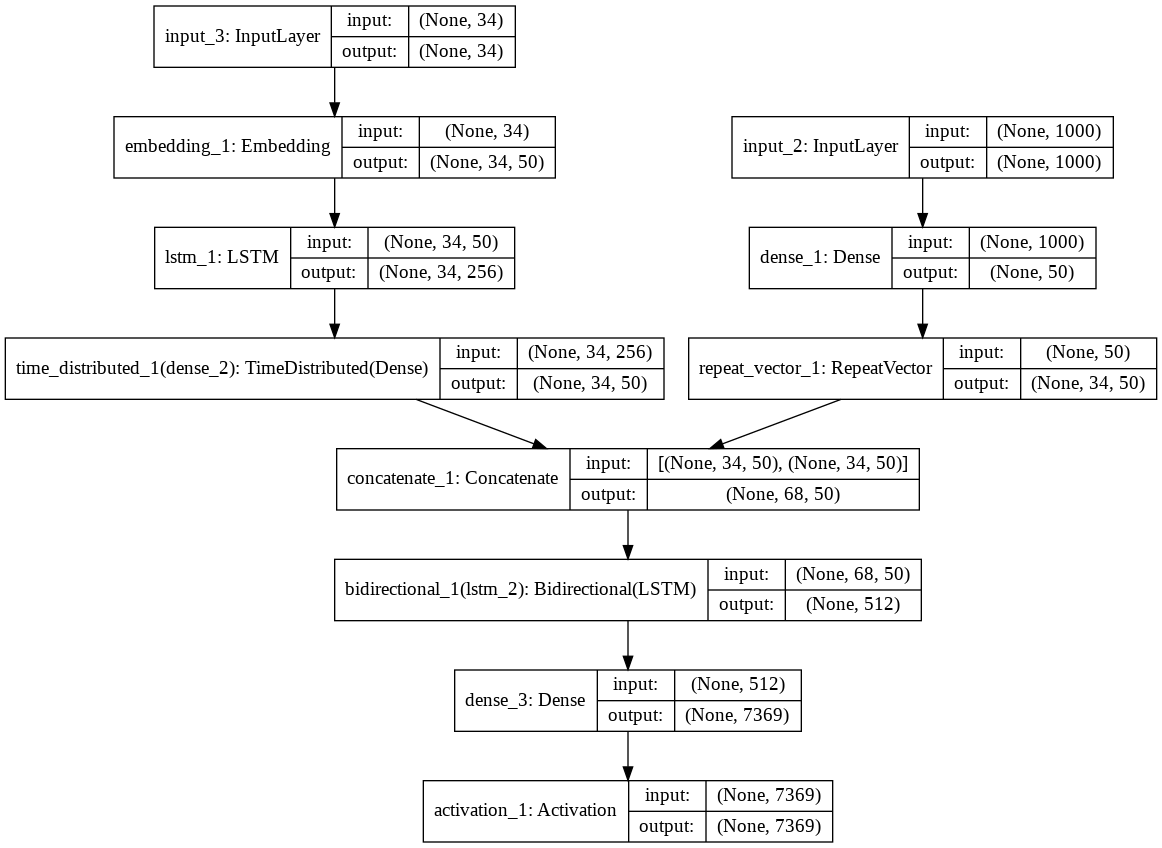

In [ ]:
from keras.utils import plot_model
plot_model(lang_model, to_file='model.png', show_shapes=True)

In [ ]:
from keras.callbacks import ModelCheckpoint

# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = lang_model.fit([images, captions], next_words, batch_size=600, epochs=20, callbacks=[checkpoint], validation_data=([vimages, vcaptions], vnext_words))

Train on 61800 samples, validate on 10560 samples
Epoch 1/20
61800/61800 [==============================] - 74s 1ms/step - loss: 6.0904 - accuracy: 0.0942 - val_loss: 5.7721 - val_accuracy: 0.0947

Epoch 00001: val_loss improved from inf to 5.77212, saving model to model-ep001-loss6.090-val_loss5.772.h5
Epoch 2/20
61800/61800 [==============================] - 62s 1ms/step - loss: 5.6798 - accuracy: 0.0971 - val_loss: 5.7896 - val_accuracy: 0.0947

Epoch 00002: val_loss did not improve from 5.77212
Epoch 3/20
61800/61800 [==============================] - 62s 1ms/step - loss: 5.6685 - accuracy: 0.0971 - val_loss: 5.7891 - val_accuracy: 0.0947

Epoch 00003: val_loss did not improve from 5.77212
Epoch 4/20
61800/61800 [==============================] - 62s 1ms/step - loss: 5.6257 - accuracy: 0.0965 - val_loss: 5.7192 - val_accuracy: 0.0947

Epoch 00004: val_loss improved from 5.77212 to 5.71923, saving model to model-ep004-loss5.626-val_loss5.719.h5
Epoch 5/20
61800/61800 [==============

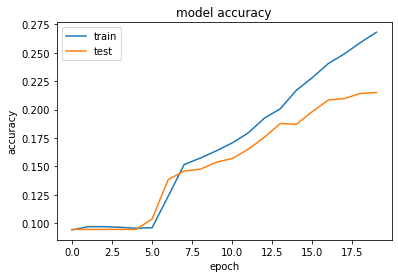

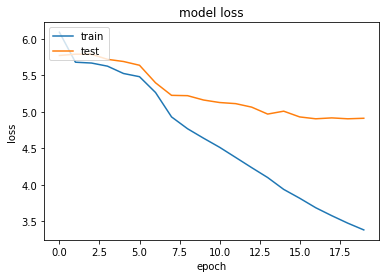

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
img_model.save('img_model_1000.h5')
lang_model.save('lang_model_1000.h5')

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 144.4MB 118kB/s 
     |████████████████████████████████| 92kB 8.5MB/s 
     |████████████████████████████████| 256kB 36.4MB/s 
     |████████████████████████████████| 921kB 35.4MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=b6b2d223df844a915aa17338970f737fe545fd85d68a03bd6ccd20ffb466b962
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: Pygments 2.1.3
    Uninstalling Pygments-2.1.3:
      Successfully uninstalled Pygments-2.1.3
  Found existing installation: tensorflow-hub 0

In [ ]:
!mkdir model1000
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(img_model, 'model1000/img_model')
tfjs.converters.save_keras_model(lang_model, 'model1000/lang_model')

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [ ]:
!cp -r /content/model1000 '/content/gdrive/My Drive'
!cp -r /content/img_model_1000.h5 '/content/gdrive/My Drive'
!cp -r /content/lang_model_1000.h5 '/content/gdrive/My Drive'

Predict

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import image

def preprocess_input(x):
  x /= 127.5
  x -= 1
  return x
  
def preprocess(image_path):
  img = load_img(image_path, target_size=(224, 224))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return x

def encode(image):
  image = preprocess(image)
  temp_enc = img_model.predict(image)
  temp_enc = np.reshape(temp_enc, 1000)
  return temp_enc

def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2index[i] for i in start_word]
        par_caps = pad_sequences([par_caps], maxlen=max_len, padding='post')
        #e = encoding_test[image[len(images):]]
        e = encode(image)
        preds = lang_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = index2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [ ]:
#Mean bleu
max_length = 34
bleus = []

for t in unique_val:
  test_img_path = os.path.join(image_folder, t)
  real_cap = next(y for x,y in val_set if x==t)
  #image = preprocess_image(test_img_path)
  #feature = img_model.predict(image)
  #feature = np.reshape(feature, feature.shape[1])

  Argmax_Search = predict_captions(test_img_path)
  pic = Image(filename=test_img_path)
  #display(pic)

  s_real = real_cap.split()
  s_real = s_real[1: -1]
  s_pred = Argmax_Search.split()
  bleu = sentence_bleu([s_real], s_pred)

  #print('Real Captions: {}'.format(''.join(real_cap)))
  #print('Predicted Captions: {}'.format(Argmax_Search))
  #print('BLEU: {}'.format(bleu))
  #print('\n')
  bleus.append(bleu)

print("Mean BLEU {}".format(np.mean(bleus)))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Mean BLEU 0.34934215717044664
